<a href="https://colab.research.google.com/github/mrMichalR/blueberry_yield/blob/main/blueberry_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Blueberry yield prediction**

In [1]:
!pip install pandas_profiling
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libraries

In [2]:
import pandas as pd
from tqdm import tqdm, trange
import numpy as np
from numpy import std, unique
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import os, sys
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from google.colab import files
from pandas import set_option
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, RFE, RFECV 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso

<ipython-input-2-aaba858bdefe>:13: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport



# Data load

## Load from Kaggle

In [3]:
# files.upload()

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [5]:
# !kaggle competitions download -c playground-series-s3e14

In [6]:
# !unzip /content/playground-series-s3e14.zip

## Load from github

In [7]:
url_train ='https://raw.githubusercontent.com/mrMichalR/blueberry_yield/main/data/train.csv'
url_test = 'https://raw.githubusercontent.com/mrMichalR/blueberry_yield/main/data/test.csv'
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

df_train['type'] = 'train'
df_test['type'] = 'test'

df_ = pd.concat([df_train, df_test])
df_ = df_.reset_index(drop=True)

df_train

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,type
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146,train
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201,train
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760,train
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590,train
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,15284,12.5,0.25,0.25,0.38,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.556302,0.476308,40.546480,7667.83619,train
15285,15285,12.5,0.25,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.354413,0.388145,29.467434,3680.56025,train
15286,15286,25.0,0.50,0.25,0.38,0.75,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.422548,0.416786,32.299059,4696.44394,train
15287,15287,25.0,0.50,0.25,0.63,0.63,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.542170,0.434133,36.674243,6772.93347,train


# EDA

## Pandas profiling

In [8]:
# description = "Disclaimer: this profiling report was generated using minimal mode"

# for number, elem in zip(range(1,4), df_list):
#   prof = elem.profile_report(dataset={"description": description}, minimal=True)
#   prof.to_notebook_iframe()
#   prof.to_file(output_file=f'ProfileReport{number}.html')

## Descriptive analysis

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10194 non-null  int64  
 1   clonesize             10194 non-null  float64
 2   honeybee              10194 non-null  float64
 3   bumbles               10194 non-null  float64
 4   andrena               10194 non-null  float64
 5   osmia                 10194 non-null  float64
 6   MaxOfUpperTRange      10194 non-null  float64
 7   MinOfUpperTRange      10194 non-null  float64
 8   AverageOfUpperTRange  10194 non-null  float64
 9   MaxOfLowerTRange      10194 non-null  float64
 10  MinOfLowerTRange      10194 non-null  float64
 11  AverageOfLowerTRange  10194 non-null  float64
 12  RainingDays           10194 non-null  float64
 13  AverageRainingDays    10194 non-null  float64
 14  fruitset              10194 non-null  float64
 15  fruitmass          

In [11]:
df_train.describe(include='all')

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield,type
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15289
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999,NaN
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850,NaN
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610,NaN
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510,NaN
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900,NaN
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380,NaN


In [12]:
df_train.nunique()

id                      15289
clonesize                   6
honeybee                    7
bumbles                    11
andrena                    16
osmia                      14
MaxOfUpperTRange            6
MinOfUpperTRange            5
AverageOfUpperTRange        5
MaxOfLowerTRange            6
MinOfLowerTRange            7
AverageOfLowerTRange        5
RainingDays                 6
AverageRainingDays          8
fruitset                 1526
fruitmass                1515
seeds                    2066
yield                     776
type                        1
dtype: int64

In [13]:
df_train.isnull().any()

id                      False
clonesize               False
honeybee                False
bumbles                 False
andrena                 False
osmia                   False
MaxOfUpperTRange        False
MinOfUpperTRange        False
AverageOfUpperTRange    False
MaxOfLowerTRange        False
MinOfLowerTRange        False
AverageOfLowerTRange    False
RainingDays             False
AverageRainingDays      False
fruitset                False
fruitmass               False
seeds                   False
yield                   False
type                    False
dtype: bool

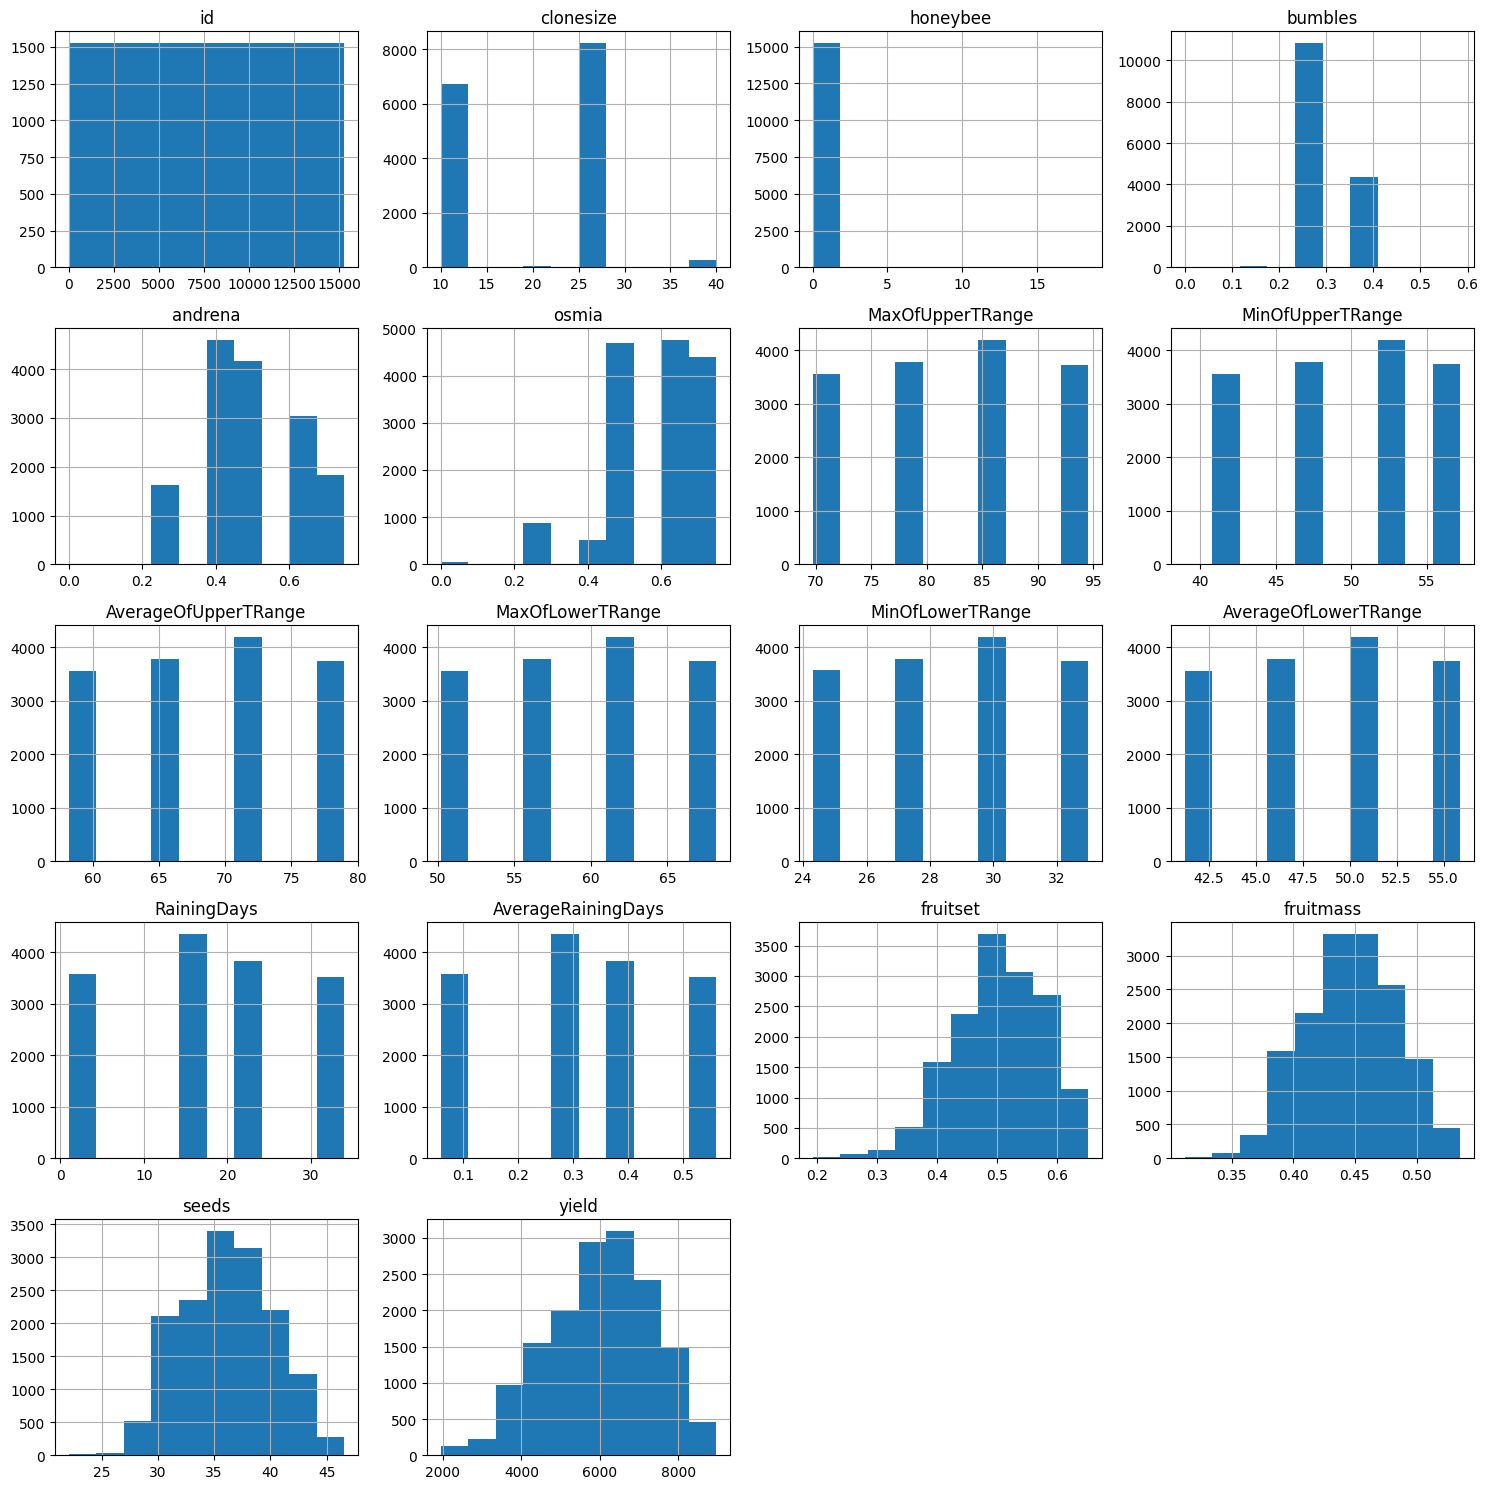

In [14]:
# histograms of each attribute to get a sense of the data distributions
df_train.hist(figsize=(15,15), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

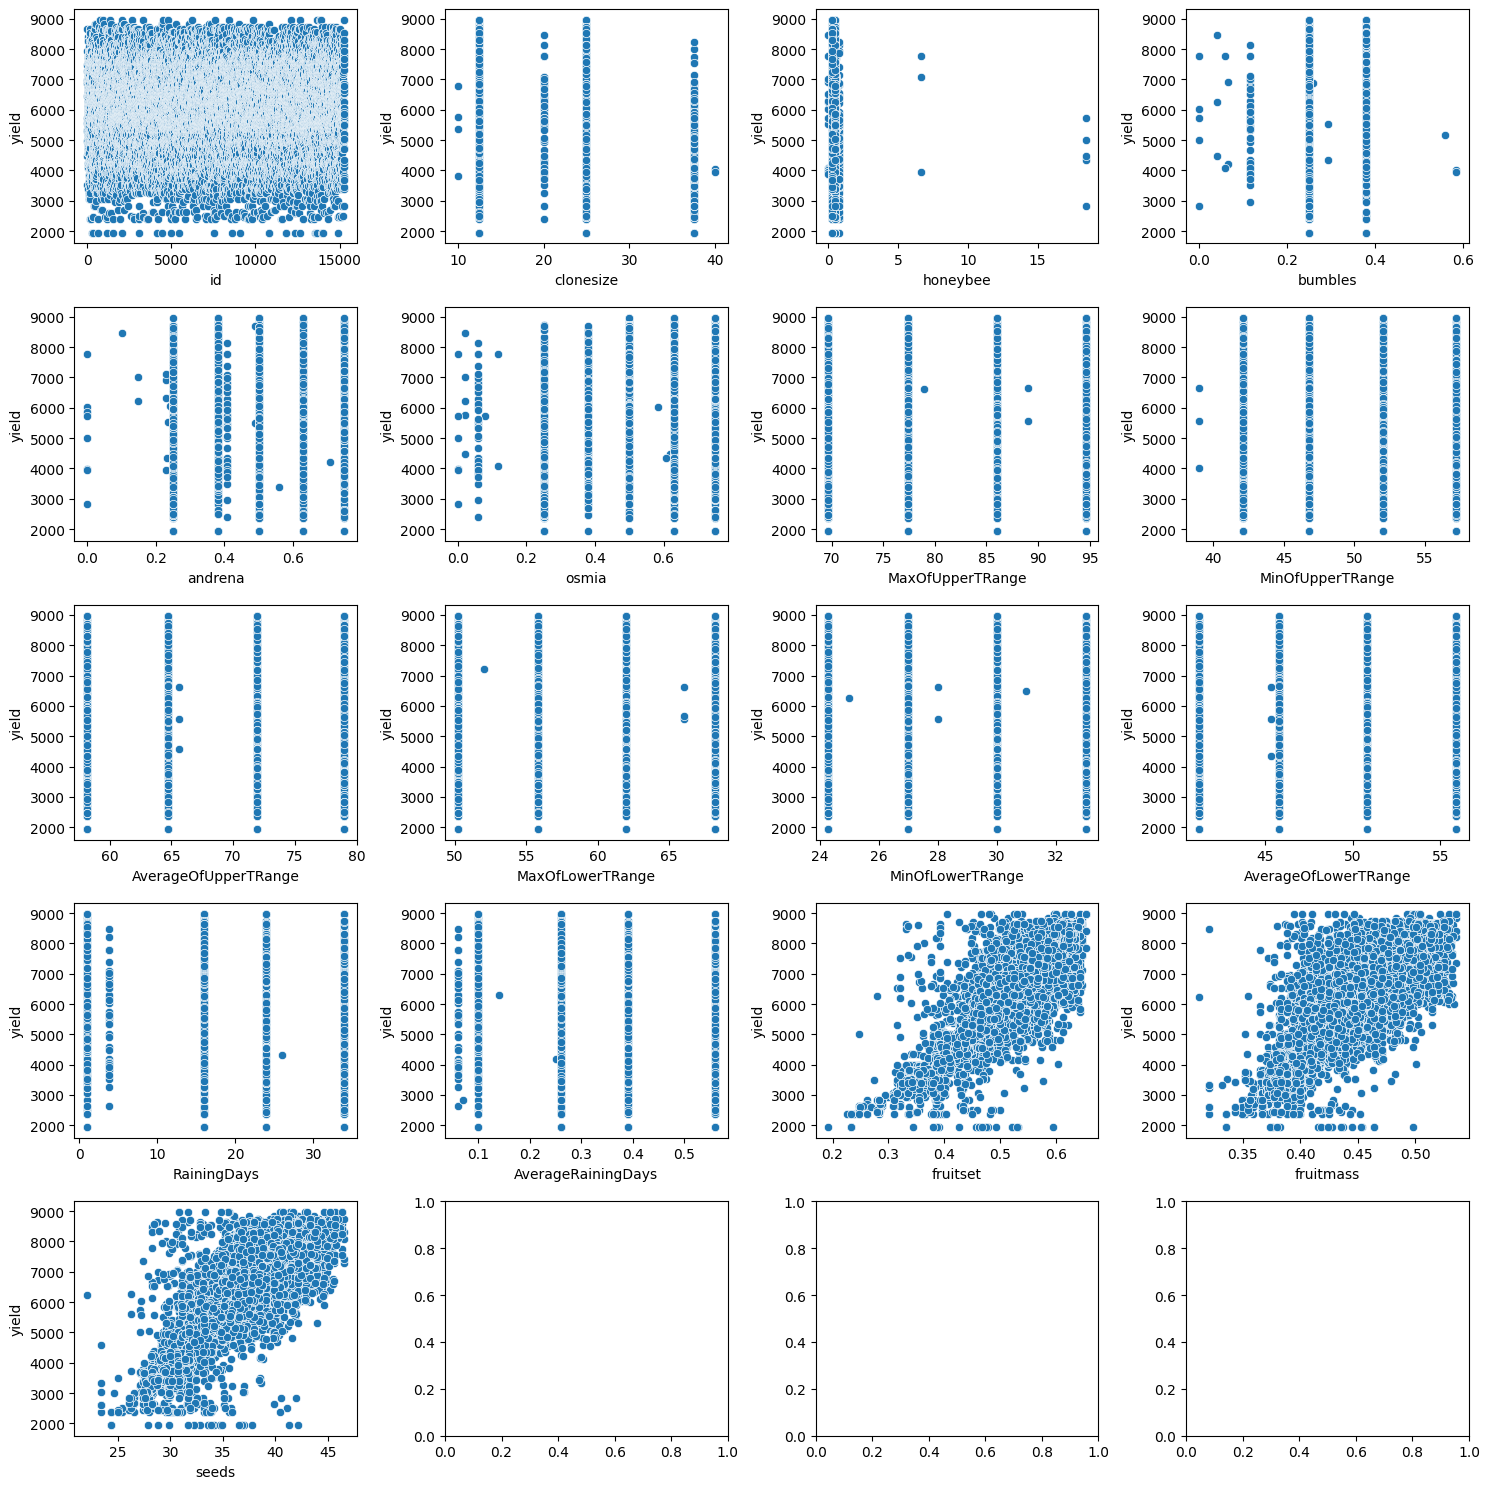

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(15, 15))
index = 0
axs = axs.flatten()
for k,v in df_train.iloc[:,0:17].items():
  sns.scatterplot(data=df_train, x=v, y='yield', legend='auto', ax=axs[index])
  index +=1
plt.tight_layout()

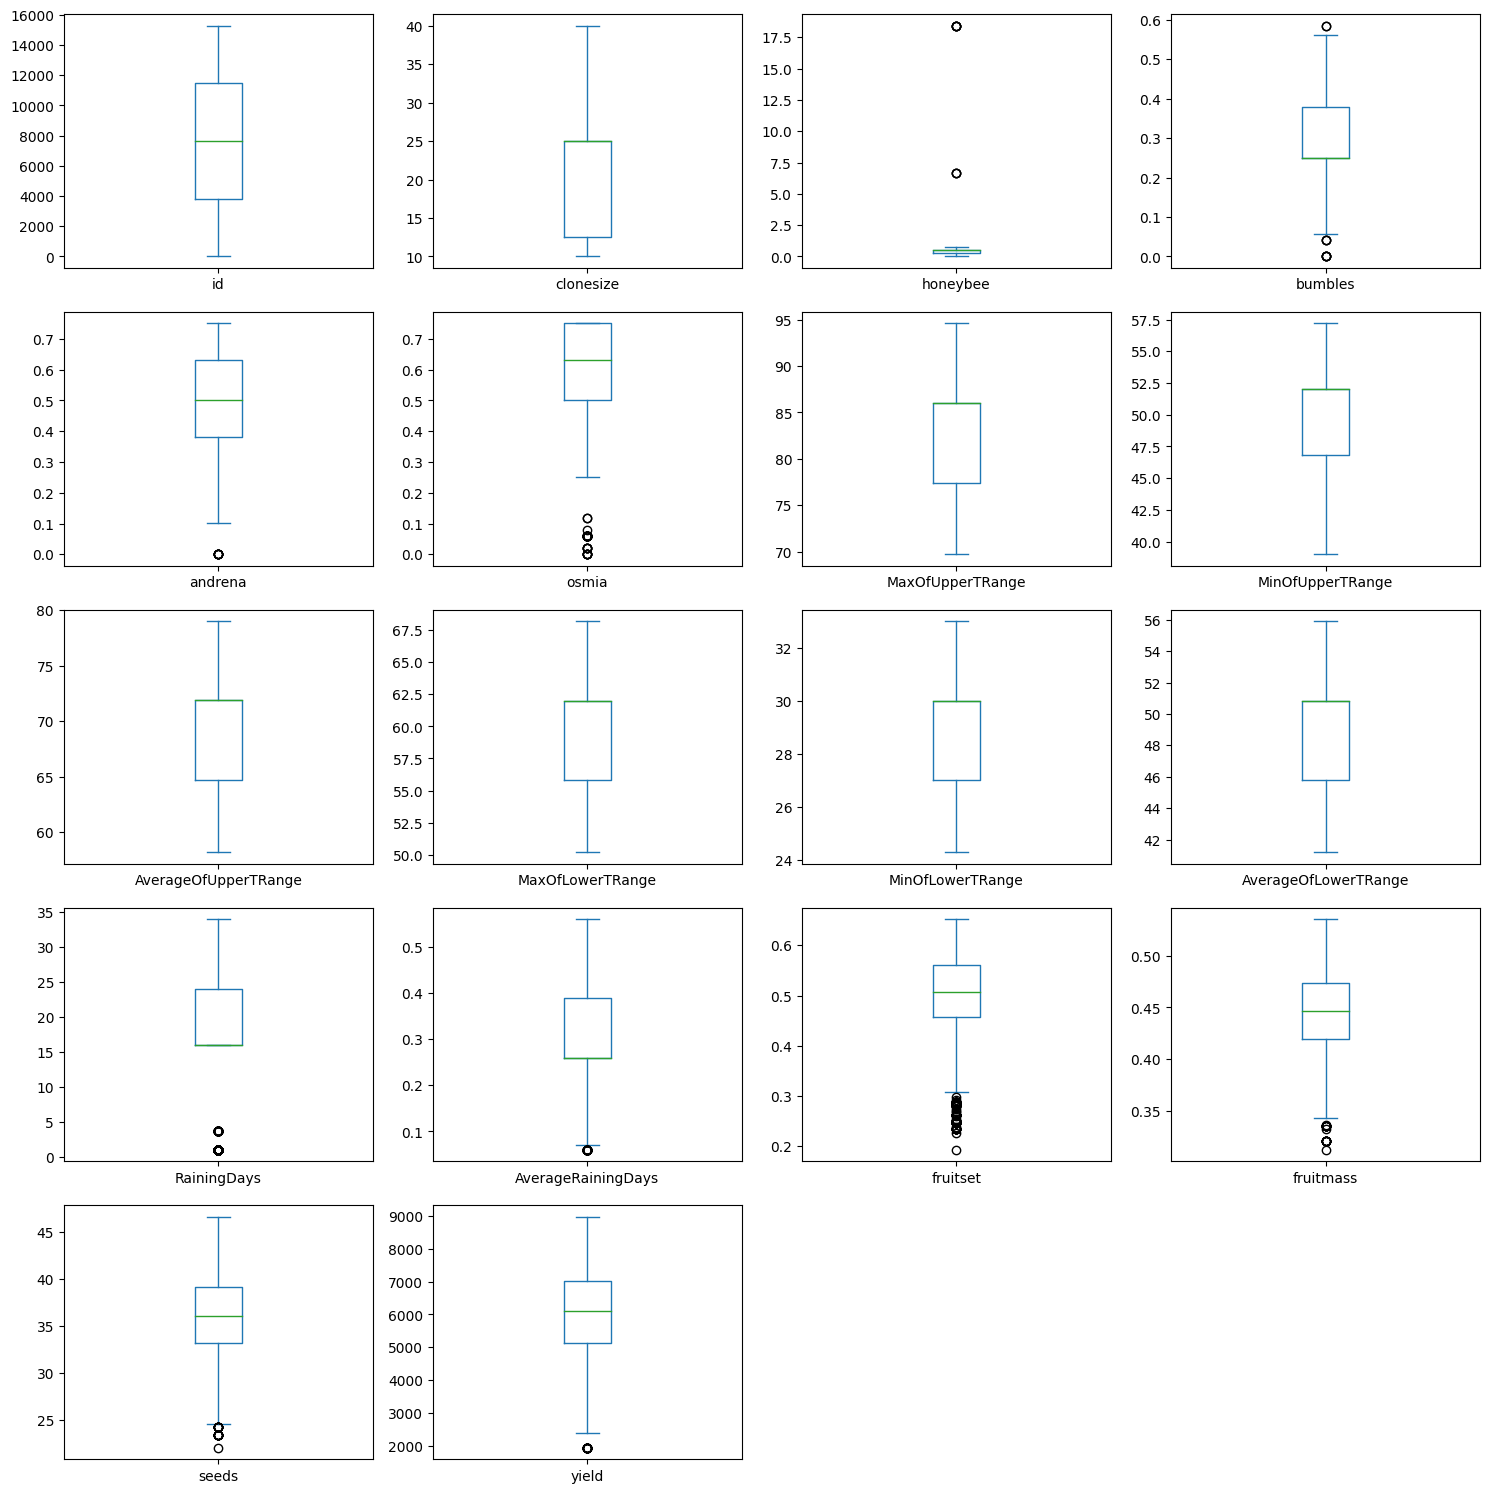

In [16]:
# box and whisker plots
df_train.plot(kind='box', figsize=(15,15), subplots=True, layout=(5,4), sharex=False, sharey=False)
plt.tight_layout()

<ipython-input-17-10087cdad1b6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(method='pearson'), annot=True, fmt='.3f')


<AxesSubplot: >

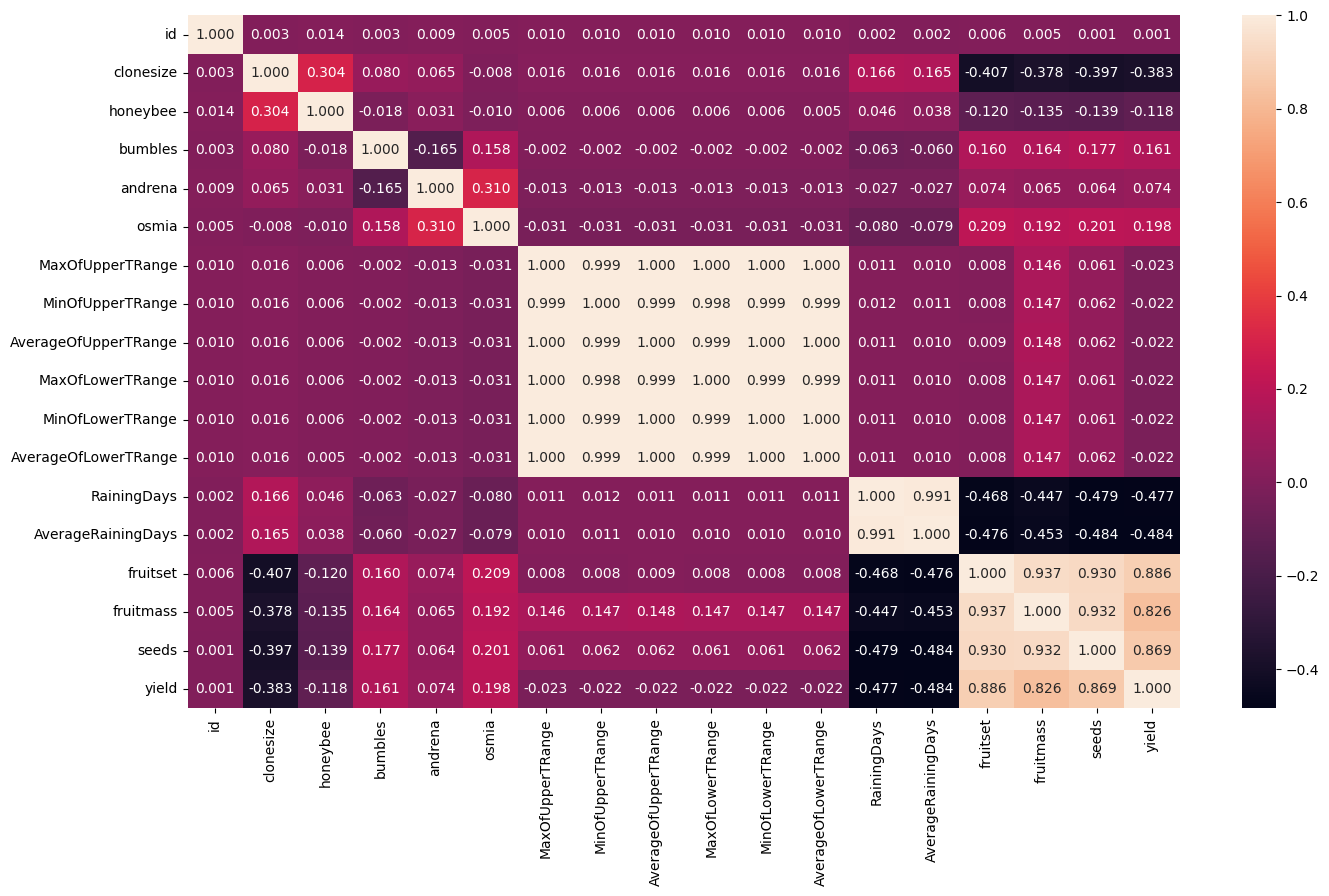

In [17]:
plt.rcParams["figure.figsize"] = [16,9]
sns.heatmap(df_train.corr(method='pearson'), annot=True, fmt='.3f')

In [18]:
cor = df_train.corr(method='pearson').abs().unstack()
cor_sort = cor.sort_values(kind="quicksort", ascending=False)
print(cor_sort['yield'])

yield                   1.000000
fruitset                0.885967
seeds                   0.868853
fruitmass               0.826481
AverageRainingDays      0.483870
RainingDays             0.477191
clonesize               0.382619
osmia                   0.198264
bumbles                 0.161145
honeybee                0.118001
andrena                 0.073969
MaxOfUpperTRange        0.022517
MinOfLowerTRange        0.022319
MaxOfLowerTRange        0.022197
AverageOfLowerTRange    0.022081
AverageOfUpperTRange    0.021940
MinOfUpperTRange        0.021929
id                      0.000975
dtype: float64


<ipython-input-18-27ba987ba7b1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_train.corr(method='pearson').abs().unstack()


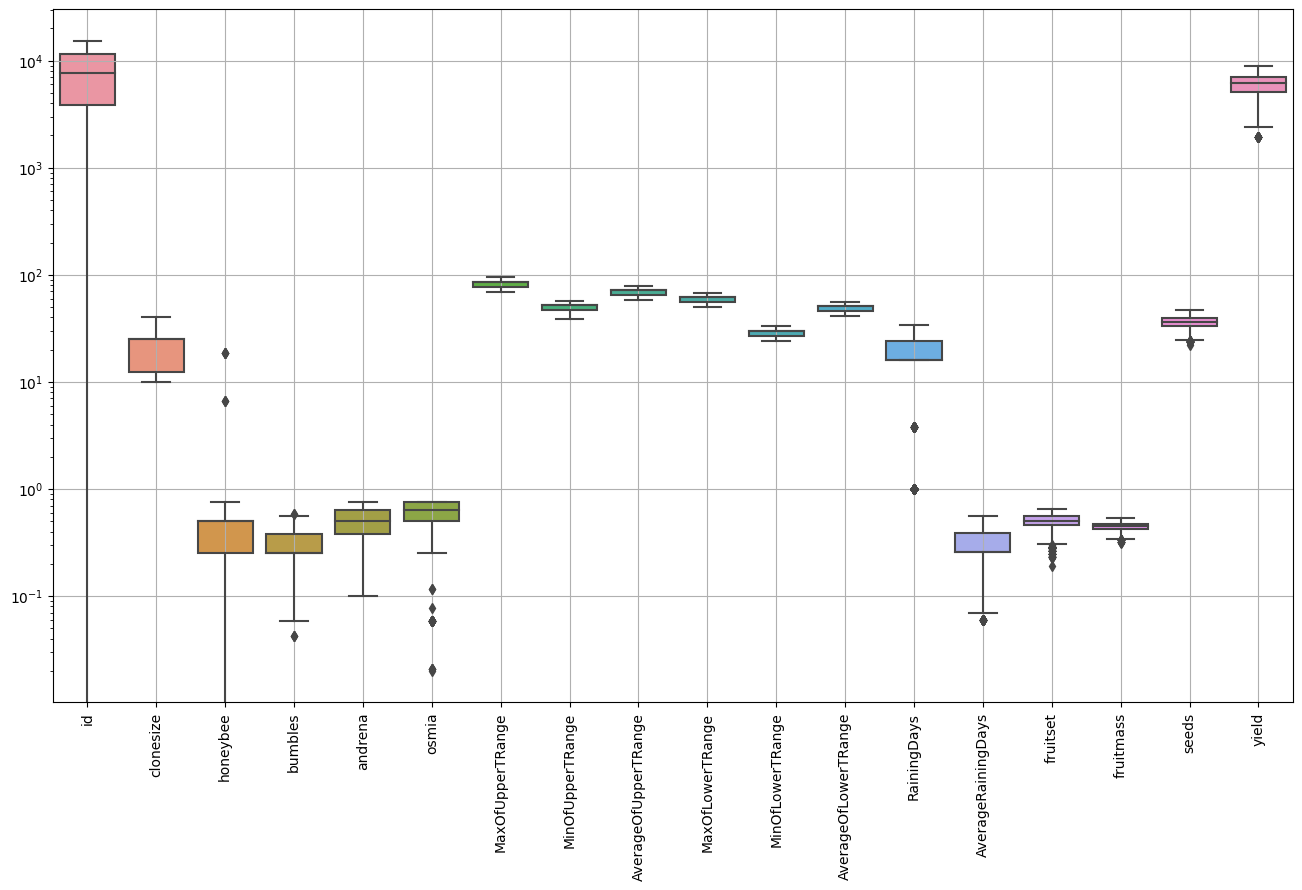

In [19]:
plt.rcParams["figure.figsize"] = [16,9]
ax = sns.boxplot(data=df_train, orient="v", showfliers=True)
ax.set_yscale("log")
plt.xticks(rotation = 90)
plt.grid(visible=True, which='major', axis='both')

SUMMARY:
- cols to drop or keep one of them:

MaxOfUpperTRange<br>
MinOfUpperTRange<br>
AverageOfUpperTRange<br>
MaxOfLowerTRange<br>
MinOfLowerTRange<br>
AverageOfLowerTRange<br>

- keep one col of fruitset, fruitmass, seeds. Rest drop 
- keep one col of RainingDays, AvarageRainingDays. Rest drop 
- CloneSize to drop?

# Data preprocessing



Drop redundant column





In [20]:
red_col = ['id']
df_train = df_train.drop(red_col, axis=1)
df_test = df_test.drop(red_col, axis=1)

Drop rows with low yield value in highly correclated columns

Acc. to scatter plots, dropping lowest yield value for columns: fruitset,	fruitmass and	seeds.

In [21]:
df_y = df_[df_['yield'] < 2100].iloc[:,14:18]
print(f'Rows with yield < 2100 is:{len(df_y)}')

df_train = df_train.drop(df_train[df_train['yield'] < 2100].index)

Rows with yield < 2100 is:26


Drop duplicates

In [22]:
# calculate duplicates
dups = df_train.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df_train[dups])
# print(df[dups].columns)


# df_train.duplicated().sum()
df_train = df_train.drop_duplicates(subset=df_train.columns[1:18], keep='first')

True
       clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
3380        25.0      0.50     0.25     0.63   0.63              86.0   
8060        12.5      0.25     0.38     0.50   0.75              77.4   
9219        37.5      0.75     0.25     0.25   0.25              77.4   
11046       25.0      0.50     0.38     0.63   0.50              86.0   
12589       37.5      0.75     0.25     0.25   0.25              86.0   
14187       12.5      0.25     0.25     0.50   0.75              94.6   
14408       12.5      0.25     0.25     0.25   0.75              69.7   

       MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
3380               52.0                  71.9              62.0   
8060               46.8                  64.7              55.8   
9219               46.8                  64.7              55.8   
11046              52.0                  71.9              62.0   
12589              52.0                  71.9              62.0   
14187   

Cleaning dataset

In [23]:
df2_train = df_train.copy()

In [24]:
group_clonesize = df_.groupby(['clonesize', 'type'])['clonesize'].size().unstack()
group_clonesize

type,test,train
clonesize,,
10.0,2.0,4.0
12.5,4412.0,6717.0
20.0,29.0,56.0
25.0,5569.0,8245.0
37.5,182.0,265.0
40.0,NaN,2.0


In [25]:
df2_train = df2_train.drop(df2_train[df2_train['clonesize'].isin([10, 20, 37.5, 40])].index)

In [26]:
group_RD = df_.groupby(['RainingDays', 'type'])['RainingDays'].size().unstack()
group_RD

type,test,train
RainingDays,,
1.00,2438.0,3521.0
3.77,39.0,48.0
16.00,2831.0,4361.0
24.00,2534.0,3837.0
26.00,NaN,1.0
33.00,1.0,NaN
34.00,2351.0,3521.0


In [27]:
df2_train = df2_train.drop(df2_train[df2_train['RainingDays'].isin([3.77, 26])].index)

In [28]:
group_ARD = df_.groupby(['AverageRainingDays', 'type'])['AverageRainingDays'].size().unstack()
group_ARD

type,test,train
AverageRainingDays,,
0.06,39.0,49.0
0.07,NaN,1.0
0.10,2438.0,3520.0
0.14,NaN,1.0
0.25,NaN,1.0
0.26,2831.0,4361.0
0.39,2534.0,3837.0
0.56,2352.0,3519.0


In [29]:
df2_train = df2_train.drop(df2_train[df2_train['AverageRainingDays'].isin([0.06, 0.07, 0.14, 0.25])].index)

In [30]:
group_honeybee = df_.groupby(['honeybee', 'type'])['honeybee'].size().unstack()
group_honeybee

type,test,train
honeybee,,
0.000,7,16
0.250,4830,7285
0.500,5245,7832
0.537,21,38
0.750,85,110
6.640,2,3
18.430,4,5


In [31]:
df2_train = df2_train.drop(df2_train[~df2_train['honeybee'].isin([0.25, 0.5])].index)

In [32]:
group_bumbles = df_.groupby(['bumbles', 'type'])['bumbles'].size().unstack()
group_bumbles

type,test,train
bumbles,,
0.000,5.0,5.0
0.042,4.0,3.0
0.058,1.0,2.0
0.065,1.0,2.0
0.117,26.0,39.0
0.250,7266.0,10856.0
0.260,NaN,1.0
0.293,NaN,2.0
0.380,2890.0,4376.0


In [33]:
df2_train = df2_train.drop(df2_train[~df2_train['bumbles'].isin([0.25, 0.38])].index)

In [34]:
group_andrena = df_.groupby(['andrena', 'type'])['andrena'].size().unstack()
group_andrena

type,test,train
andrena,,
0.000,4.0,8.0
0.101,NaN,1.0
0.147,1.0,2.0
0.229,1.0,4.0
0.234,NaN,1.0
0.235,NaN,1.0
0.240,NaN,1.0
0.250,1097.0,1624.0
0.260,1.0,NaN


In [35]:
df2_train = df2_train.drop(df2_train[~df2_train['andrena'].isin([0.25, 0.38, 0.5, 0.63, 0.75])].index)

In [36]:
group_osmia = df_.groupby(['osmia', 'type'])['osmia'].size().unstack()
group_osmia

type,test,train
osmia,,
0.000,4.0,6.0
0.020,NaN,1.0
0.021,1.0,4.0
0.033,1.0,NaN
0.058,22.0,42.0
0.060,1.0,NaN
0.078,NaN,1.0
0.101,1.0,NaN
0.117,1.0,2.0


In [37]:
df2_train = df2_train.drop(df2_train[~df2_train['osmia'].isin([0.25, 0.38, 0.5, 0.63, 0.75])].index)

Drop other columns

In [38]:
col_drop = [
  'MaxOfUpperTRange',
  'MinOfUpperTRange',
  'AverageOfUpperTRange',
  'MaxOfLowerTRange',
  'MinOfLowerTRange',
  'AverageOfLowerTRange',
  'RainingDays',
  'type'
]

df_reduced = df_train.drop(col_drop, axis=1)

In [39]:
df_reduced

,clonesize,honeybee,bumbles,andrena,osmia,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,0.39,0.579677,0.494165,40.484512,7479.93417
...,...,...,...,...,...,...,...,...,...,...
15284,12.5,0.25,0.25,0.38,0.50,0.26,0.556302,0.476308,40.546480,7667.83619
15285,12.5,0.25,0.25,0.25,0.50,0.56,0.354413,0.388145,29.467434,3680.56025
15286,25.0,0.50,0.25,0.38,0.75,0.56,0.422548,0.416786,32.299059,4696.44394
15287,25.0,0.50,0.25,0.63,0.63,0.39,0.542170,0.434133,36.674243,6772.93347


# Feature selection - check

In [40]:
# feature selection f_regression
def select_features(X_train, y_train, X_test):
  # configure to select all features
  fs = SelectKBest(score_func=f_regression, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs


# mutual feature selection
def select_features_mutual(X_train, y_train, X_test):
  # configure to select all features
  fs_mut = SelectKBest(score_func=mutual_info_regression, k='all')
  # learn relationship from training data
  fs_mut.fit(X_train, y_train)
  # transform train input data
  X_train_fs_mut = fs.transform(X_train)
  # transform test input data
  X_test_fs_mut = fs.transform(X_test)
  return X_train_fs_mut, X_test_fs_mut, fs_mut

In [41]:
# preparing dataset for feature selection methods
X_train_for_fs = df_train.drop(['yield', 'type'], axis=1)
y_train_for_fs = df_train['yield']
X_test_for_fs = df_test.drop(['type'], axis=1)

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_for_fs, y_train_for_fs , X_test_for_fs)

# what are scores for the features
fs_df = pd.concat([
    pd.DataFrame(X_train_for_fs.columns, columns=['feature']),
    pd.DataFrame(fs.scores_, columns=['fs_score'])], axis=1).sort_values(by='fs_score', ascending=False)

fig = px.bar(fs_df.sort_values(by='fs_score'), x='fs_score', y='feature',
             height=600, width=800, 
             title='Feature importances for Mutual info Regression metod')

fig.show()

In [42]:
# mutual feature selection
X_train_fs_mut, X_test_fs_mut, fs_mut = select_features_mutual(X_train_for_fs, y_train_for_fs , X_test_for_fs)

# what are scores for the features
fs_mut_df = pd.concat([
    pd.DataFrame(X_train_for_fs.columns, columns=['feature']),
    pd.DataFrame(fs_mut.scores_, columns=['fs_score'])], axis=1).sort_values(by='fs_score', ascending=False)

fig = px.bar(fs_mut_df.sort_values(by='fs_score'), x='fs_score', y='feature',
             height=600, width=800, 
             title='Feature importances for Mutual info Regression metod')

fig.show()

# Model build

##  Dataset train-test split

In [43]:
# Split-out validation dataset
test_size1 = 0.33
test_size2 = 0.25
test_size3 = 0.20

train_data = df_train.drop(['yield','type'], axis=1)
train_target = df_train['yield']

def split_data(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train_data, train_target, test_size1)
X_train_select_kbest, X_test_select_kbest, y_train_select_kbest, y_test_select_kbest = split_data(X_train_fs, train_target, test_size1)
X_train_select_mut, X_test_select_mut, y_train_select_mut, y_test_select_mut = split_data(X_train_fs_mut, train_target, test_size1)
# x_train df_train2 ?
# x_train df_reduced ?

print("X_train dimension = ", X_train.shape)
print("X_test dimension = ", X_test.shape)
print("y_train dimension = ", y_train.shape)
print("y_train dimension = ", y_test.shape)
# X_train.reset_index(inplace=True, drop=True)
# X_test.reset_index(inplace=True, drop=True)
# y_train.reset_index(inplace=True, drop=True)
# y_test.reset_index(inplace=True, drop=True)

print("X_train_selected dimension = ", X_train_select_kbest.shape)
print("X_test_selected dimension = ", X_test_select_kbest.shape)
print("y_train_selected dimension = ", y_train_select_kbest.shape)
print("y_train_selected dimension = ", y_test_select_kbest.shape)

print("X_train_mutual dimension = ", X_train_select_mut.shape)
print("X_test_mutual dimension = ", X_test_select_mut.shape)
print("y_train_mutual dimension = ", y_train_select_mut.shape)
print("y_train_mutual dimension = ", y_test_select_mut.shape)

X_train dimension =  (10220, 16)
X_test dimension =  (5035, 16)
y_train dimension =  (10220,)
y_train dimension =  (5035,)
X_train_selected dimension =  (10220, 16)
X_test_selected dimension =  (5035, 16)
y_train_selected dimension =  (10220,)
y_train_selected dimension =  (5035,)
X_train_mutual dimension =  (10220, 16)
X_test_mutual dimension =  (5035, 16)
y_train_mutual dimension =  (10220,)
y_train_mutual dimension =  (5035,)


## Evaluate Algorithms: Baseline

In [47]:
# Test options and evaluation metric
num_folds = 10
scoring = 'neg_mean_absolute_error'
evaluation_results={}
results = []
names = []

In [45]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(tol=0.05)))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(kernel='linear', gamma='auto')))

**Evaluate on plain data**

In [89]:
# evaluate each model in turn

for name, model in tqdm(models):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, train_data, train_target, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s %s: %f (%f)" % (name, '(plain)' ,cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:00<00:02,  2.46it/s]

LR (plain): -368.756959 (8.735487)


 33%|███▎      | 2/6 [00:00<00:01,  2.39it/s]

LASSO (plain): -376.043077 (8.663276)


 50%|█████     | 3/6 [00:02<00:03,  1.17s/it]

EN (plain): -429.850237 (13.709077)


 67%|██████▋   | 4/6 [00:04<00:02,  1.46s/it]

KNN (plain): -448.521878 (11.849511)


 83%|████████▎ | 5/6 [00:06<00:01,  1.47s/it]

CART (plain): -518.961149 (10.198299)


 83%|████████▎ | 5/6 [00:35<00:07,  7.12s/it]


KeyboardInterrupt: ignored

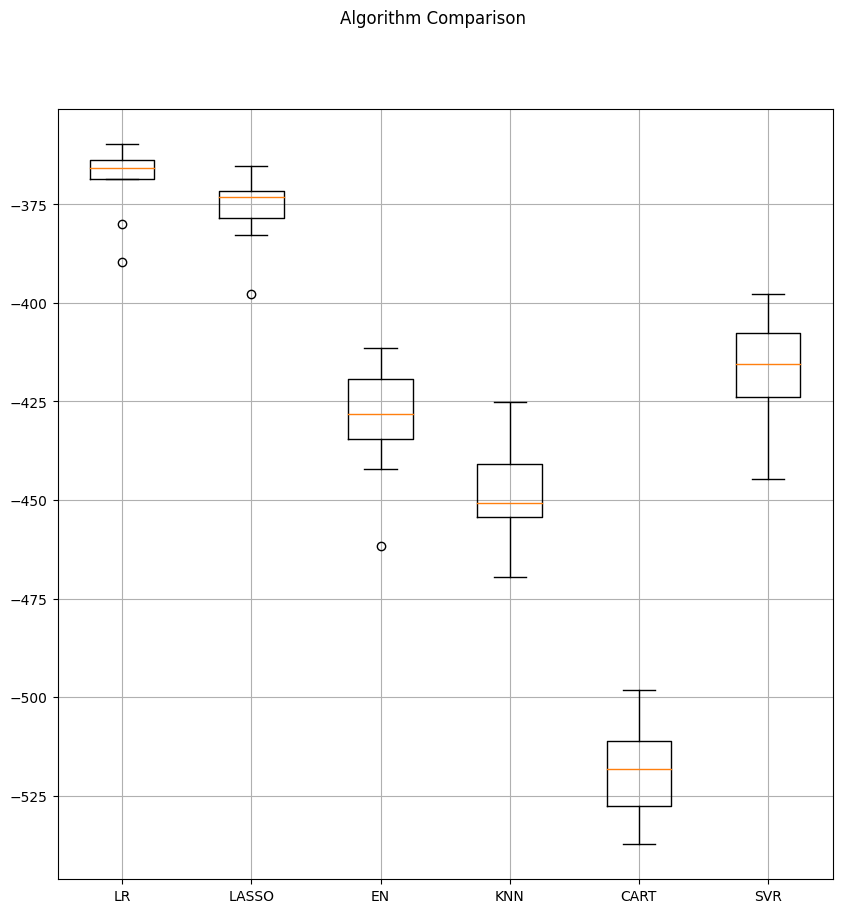

In [47]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

Baseline best model: LR

In [90]:
evaluation_results

{'LR': -368.75695861636086,
 'LASSO': -376.0430765227738,
 'EN': -429.8502373572689,
 'KNN': -448.521877704675,
 'CART': -518.9611492314305,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -372.06157190141494,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -518.0312215008764,
 'Normalized SVR': -569.5600323188185,
 'Scaled LR': -368.31312246315275,
 'Scaled LASSO': -368.58973770882915,
 'Scaled EN': -437.08073593977076,
 'Scaled KNN': -436.56557590398154,
 'Scaled CART': -517.916679931842,
 'Scaled SVR': -370.23802721791776,
 'AB': -508.0325976012693,
 'GBM': -350.48066864437317,
 'RF': -362.86660686793704,
 'ET': -373.42552363182324,
 'CatB': -349.98688839740936,
 'LGBM': -349.5591466110024,
 'Scaled AB': -510.3225917935242,
 'Scaled GBM': -350.56161651321577,
 'Scaled RF': -362.31653173764556,
 'Scaled ET': -373.0088553901015,
 'Scaled CatB': -350.43273582357403,
 'Scaled 

**Evaluate on selected features (f_regression)**

In [48]:
for name, model in tqdm(models):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, X_train_fs, train_target, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append([str(name)+str(fs)])
      msg = "%s %s: %f (%f)" % (name,'(f_reg)', cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:00<00:01,  3.02it/s]

LR (f_reg): -368.756959 (8.735487)


 33%|███▎      | 2/6 [00:00<00:01,  2.96it/s]

LASSO (f_reg): -376.043077 (8.663276)


 50%|█████     | 3/6 [00:02<00:03,  1.09s/it]

EN (f_reg): -429.850237 (13.709077)


 67%|██████▋   | 4/6 [00:05<00:03,  1.91s/it]

KNN (f_reg): -448.521878 (11.849511)


 83%|████████▎ | 5/6 [00:08<00:02,  2.13s/it]

CART (f_reg): -519.298580 (10.298056)


100%|██████████| 6/6 [03:02<00:00, 30.34s/it]

SVR (f_reg): -417.495466 (13.032774)


In [50]:
evaluation_results

{'LR': -368.7569586164256,
 'LASSO': -376.0430765227738,
 'EN': -429.85023735726884,
 'KNN': -448.521877704675,
 'CART': -518.9742258150401,
 'SVR': -417.49546621946973}

**Evaluate on selected features (mutual info)**

In [51]:
for name, model in tqdm(models):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, X_train_fs_mut, train_target, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s $s: %f (%f)" % (name,'(mutual_info)',cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:00<00:01,  2.88it/s]

LR (mutual_info): -368.756959 (8.735487)


 33%|███▎      | 2/6 [00:00<00:01,  2.28it/s]

LASSO (mutual_info): -376.043077 (8.663276)


 50%|█████     | 3/6 [00:03<00:03,  1.24s/it]

EN (mutual_info): -429.850237 (13.709077)


 67%|██████▋   | 4/6 [00:06<00:04,  2.04s/it]

KNN (mutual_info): -448.521878 (11.849511)


 83%|████████▎ | 5/6 [00:07<00:01,  1.76s/it]

CART (mutual_info): -521.325178 (14.887643)


100%|██████████| 6/6 [02:05<00:00, 20.92s/it]

SVR (mutual_info): -417.495466 (13.032774)


In [52]:
evaluation_results

{'LR': -368.7569586164256,
 'LASSO': -376.0430765227738,
 'EN': -429.85023735726884,
 'KNN': -448.521877704675,
 'CART': -521.3251782411944,
 'SVR': -417.49546621946973}

**Evaluate on cleaned data (df2_train)**

In [53]:
for name, model in tqdm(models):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, df2_train.iloc[:,0:16], df2_train['yield'], cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s $s: %f (%f)" % (name,'(df2_train)', cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:00<00:02,  2.42it/s]

LR (df2_train): -368.313122 (9.339065)


 33%|███▎      | 2/6 [00:01<00:02,  1.65it/s]

LASSO (df2_train): -375.617146 (9.106763)


 50%|█████     | 3/6 [00:02<00:03,  1.06s/it]

EN (df2_train): -427.091448 (13.584696)


 67%|██████▋   | 4/6 [00:06<00:04,  2.13s/it]

KNN (df2_train): -443.951298 (12.711775)


 83%|████████▎ | 5/6 [00:09<00:02,  2.56s/it]

CART (df2_train): -518.592512 (6.335168)


100%|██████████| 6/6 [02:23<00:00, 23.98s/it]

SVR (df2_train): -415.781511 (12.975681)


In [54]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296}

Small improvement of some algorithms

**Evaluate on reduced df (df_reduced**)

In [55]:
# evaluate each model in turn
results = []
names = []
range_ = range(0, 10)
total = len(range_)

for name, model in tqdm(models):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, df_reduced.iloc[:,0:9], df_reduced.iloc[:,-1], cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s %s: %f (%f)" % (name,'(df_reduced)', cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results | {name: cv_results.mean()}

 17%|█▋        | 1/6 [00:00<00:02,  1.92it/s]

LR (df_reduced): -369.100823 (8.214997)


 33%|███▎      | 2/6 [00:00<00:01,  2.05it/s]

LASSO (df_reduced): -378.024049 (7.710338)


 50%|█████     | 3/6 [00:01<00:01,  2.27it/s]

EN (df_reduced): -440.996247 (12.960467)


 67%|██████▋   | 4/6 [00:02<00:01,  1.47it/s]

KNN (df_reduced): -447.852634 (11.430770)


 83%|████████▎ | 5/6 [00:03<00:00,  1.04it/s]

CART (df_reduced): -527.157623 (12.568686)


100%|██████████| 6/6 [02:30<00:00, 25.15s/it]

SVR (df_reduced): -425.052147 (12.849482)


In [56]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296}

## Evaluate Algorithm: PolynomialFeatures

In [57]:
poly_2 = PolynomialFeatures(degree=2)

model_poly_2deg = LinearRegression()

X_train_poly_2 = poly_2.fit_transform(df_train.iloc[:,:16])
X_test_poly_2 = poly_2.transform(df_test.iloc[:,0:16])

model_poly_2deg.fit(X_train_poly_2, df_train['yield'])

LinearRegression()

In [58]:
#2nd degree
pred_2deg_train = model_poly_2deg.predict(X_train_poly_2)
pred_2deg_test = model_poly_2deg.predict(X_test_poly_2)

In [59]:
def regression_results(y_true, y_pred):
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    return round(mean_absolute_error, 4)

In [60]:
print('Polynomial features: ', regression_results(df_train['yield'], pred_2deg_train))

Polynomial features:  361.7299


In [61]:
poly_result = regression_results(df_train['yield'], pred_2deg_train)
evaluation_results.update({'Poly Feat': poly_result})
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299}

## Evaluate Algorithms: Normalization

In [62]:
# Normalization the dataset
pipelines = []
pipelines.append(('Normalized LR', Pipeline([('Normalized', MinMaxScaler()),('LR', LinearRegression())])))
pipelines.append(('Normalized LASSO', Pipeline([('Normalized', MinMaxScaler()),('LASSO', Lasso(tol=0.05))])))
pipelines.append(('Normalized EN', Pipeline([('Normalized', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('Normalized KNN', Pipeline([('Normalized', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('Normalized CART', Pipeline([('Normalized', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('Normalized SVR', Pipeline([('Normalized', MinMaxScaler()),('SVR', SVR(kernel='linear', gamma='auto'))])))

results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, df_train.iloc[:,0:16], df_train['yield'], cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  evaluation_results.update({name: cv_results.mean()})

Normalized LR: -368.756959 (8.735487)
Normalized LASSO: -372.061572 (7.444551)
Normalized EN: -892.088780 (14.368321)
Normalized KNN: -445.307772 (5.232904)
Normalized CART: -518.031222 (11.329807)
Normalized SVR: -569.560032 (9.482624)


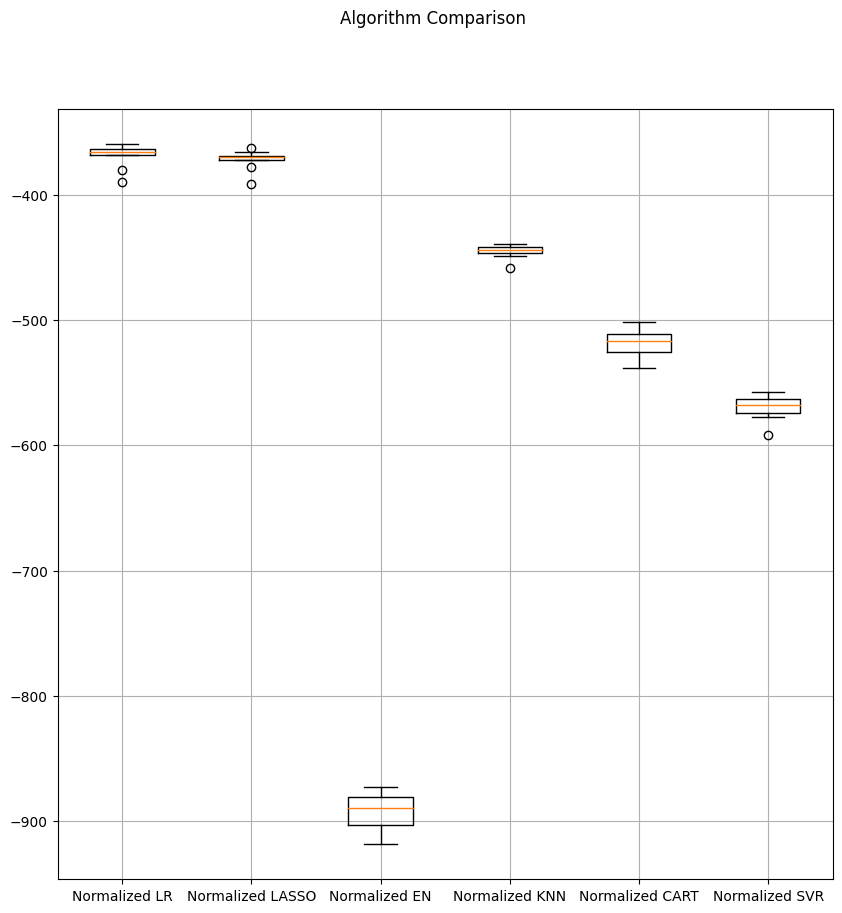

In [63]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

## Evaluate Algorithms: Standardization

In [64]:
# Standardize the dataset
pipelines = []
pipelines.append(('Scaled LR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('Scaled LASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso(tol=0.05))])))
pipelines.append(('Scaled EN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('Scaled KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('Scaled CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('Scaled SVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(kernel='linear', gamma='auto'))])))

results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, df_train.iloc[:,0:16], df_train['yield'], cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  evaluation_results.update({name: cv_results.mean()})

Scaled LR: -368.756959 (8.735487)
Scaled LASSO: -369.175675 (8.511918)
Scaled EN: -439.849177 (7.621545)
Scaled KNN: -438.074579 (5.819491)
Scaled CART: -523.072562 (11.828980)
Scaled SVR: -370.680718 (7.039604)


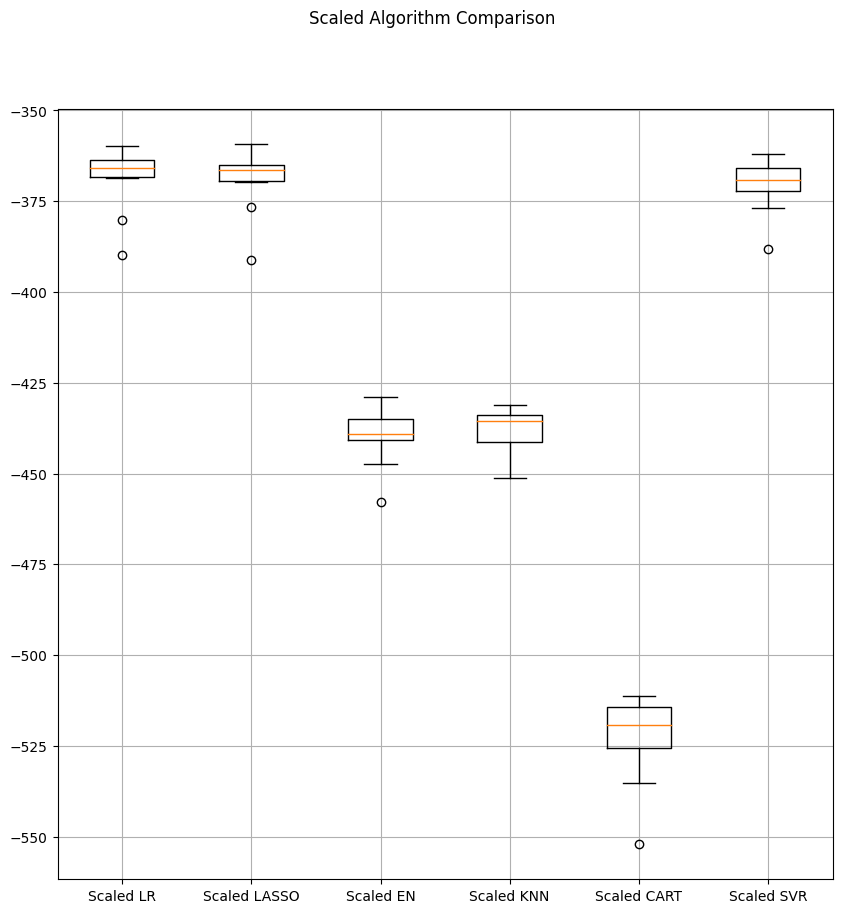

In [65]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

Evaluate on df2_train



In [66]:
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, df2_train.iloc[:,0:16], df2_train['yield'], cv=kfold, scoring=scoring) 
  results.append(cv_results)
  names.append(name)
  msg = "%s %s: %f (%f)" % (name,'(df2_train)', cv_results.mean(), cv_results.std())
  print(msg)
  evaluation_results.update({name: cv_results.mean()})

Scaled LR (df2_train): -368.313122 (9.339065)
Scaled LASSO (df2_train): -368.589738 (8.891392)
Scaled EN (df2_train): -437.080736 (7.738751)
Scaled KNN (df2_train): -436.565576 (6.255722)
Scaled CART (df2_train): -517.916680 (8.696737)
Scaled SVR (df2_train): -370.238027 (7.705292)


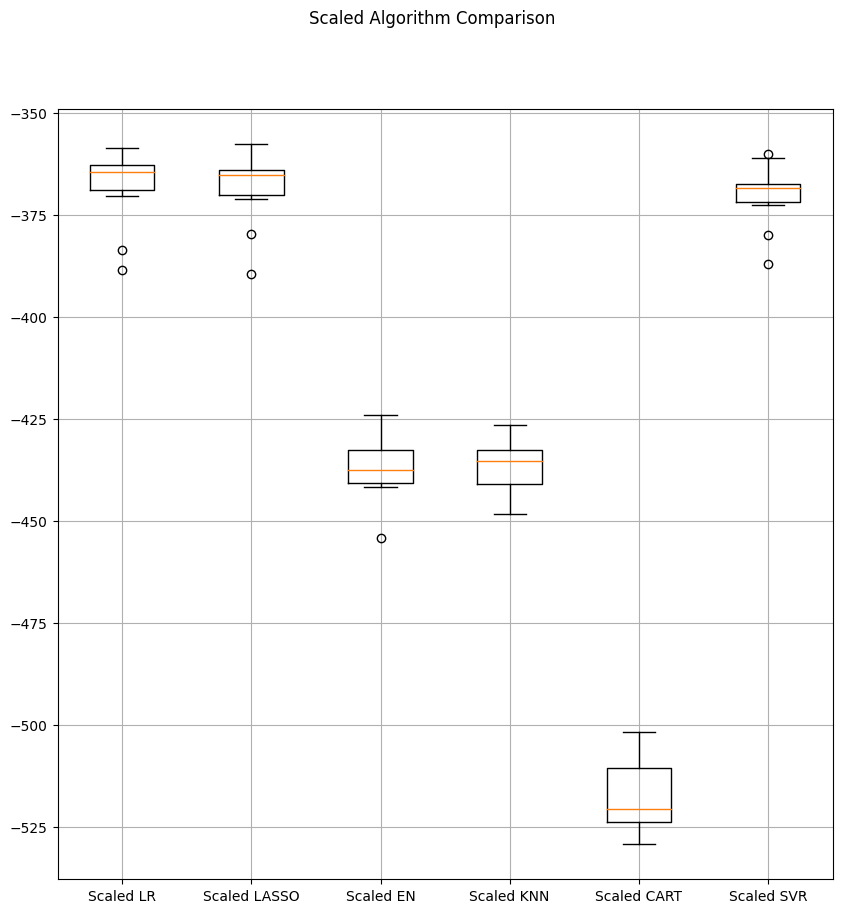

In [67]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

In [68]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -372.06157190141494,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -518.0312215008764,
 'Normalized SVR': -569.5600323188185,
 'Scaled LR': -368.31312246315275,
 'Scaled LASSO': -368.58973770882915,
 'Scaled EN': -437.08073593977076,
 'Scaled KNN': -436.56557590398154,
 'Scaled CART': -517.916679931842,
 'Scaled SVR': -370.23802721791776}

In [ ]:
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, df_train.iloc[:,0:16], df_train['yield'], cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s %s: %f (%f)" % (name, '(df_reduced)', cv_results.mean(), cv_results.std())
  print(msg)
  evaluation_results.update({name: cv_results.mean()})

Scaled LR: -368.756959 (8.735487)
Scaled LASSO: -369.175675 (8.511918)
Scaled EN: -439.849177 (7.621545)
Scaled KNN: -438.074579 (5.819491)
Scaled CART: -523.072562 (11.828980)
Scaled SVR: -370.680718 (7.039604)


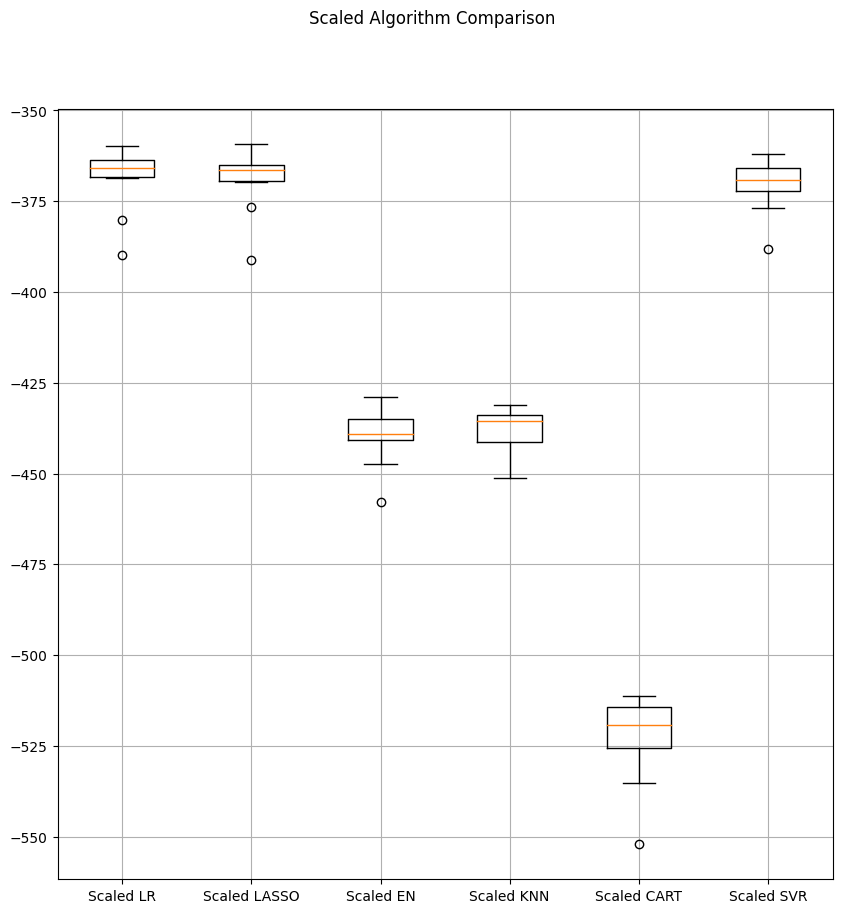

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

## Ensemble Methods

Ensemble methods trained on 'plain' data

In [69]:
# ensembles
ensembles = []
ensembles.append(('AB', Pipeline([('AB', AdaBoostRegressor())])))
ensembles.append(('GBM', Pipeline([('GBM', GradientBoostingRegressor())])))
ensembles.append(('RF', Pipeline([('RF', RandomForestRegressor())])))
ensembles.append(('ET', Pipeline([('ET', ExtraTreesRegressor())])))
ensembles.append(('CatB', Pipeline([('CatB', CatBoostRegressor(verbose=False))])))
ensembles.append(('LGBM', Pipeline([('LGMB', LGBMRegressor())])))

results = []
names = []
for name, model in tqdm(ensembles):
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, df_train.iloc[:,0:16], df_train['yield'], cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:04<00:23,  4.64s/it]

AB: -510.232610 (26.017322)


 33%|███▎      | 2/6 [00:26<00:58, 14.60s/it]

GBM: -350.469846 (7.031371)


 50%|█████     | 3/6 [01:59<02:31, 50.43s/it]

RF: -362.029635 (6.930271)


 67%|██████▋   | 4/6 [03:01<01:50, 55.05s/it]

ET: -373.271433 (6.906252)


 83%|████████▎ | 5/6 [03:48<00:52, 52.04s/it]

CatB: -349.986888 (6.308335)


100%|██████████| 6/6 [03:55<00:00, 39.21s/it]

LGBM: -349.559147 (6.411324)


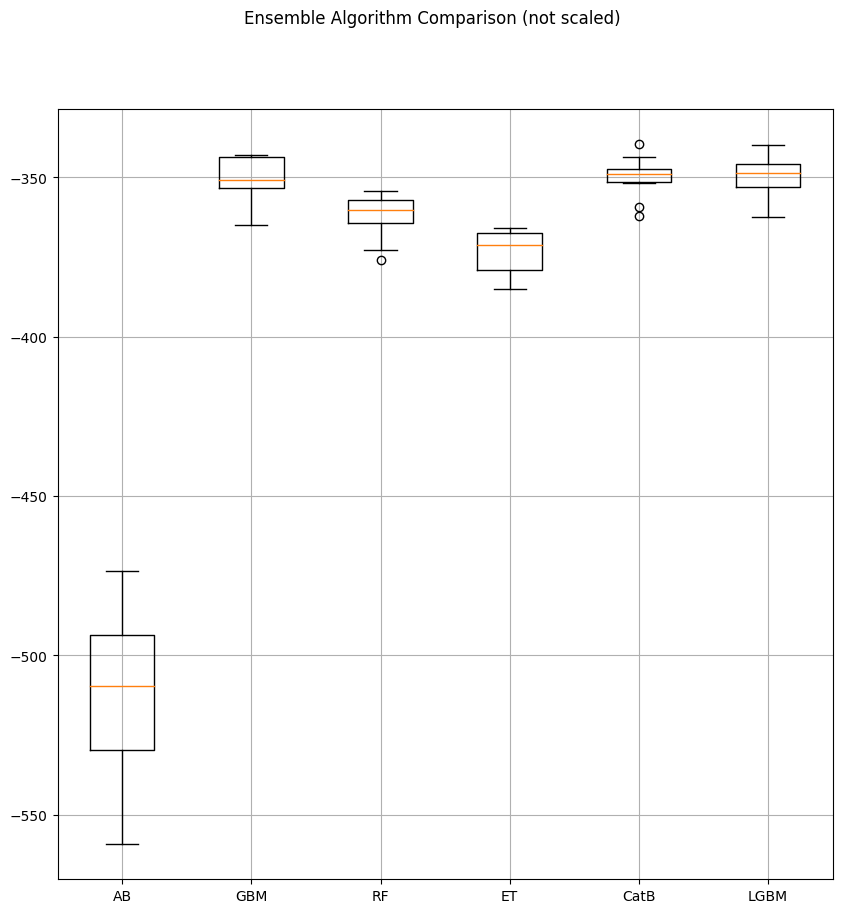

In [70]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Ensemble Algorithm Comparison (not scaled)')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

In [71]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -372.06157190141494,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -518.0312215008764,
 'Normalized SVR': -569.5600323188185,
 'Scaled LR': -368.31312246315275,
 'Scaled LASSO': -368.58973770882915,
 'Scaled EN': -437.08073593977076,
 'Scaled KNN': -436.56557590398154,
 'Scaled CART': -517.916679931842,
 'Scaled SVR': -370.23802721791776,
 'AB': -510.23261034658907,
 'GBM': -350.4698459301345,
 'RF': -362.02963482210936,
 'ET': -373.2714333442152,
 'CatB': -349.98688839740936,
 'LGBM': -349.5591466110024}

Ensemble methods with feature selection (f_regression)

In [72]:
for name, model in tqdm(ensembles):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, X_train_fs, df_train['yield'], cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s %s: %f (%f)" % (name, '(f_reg)', cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:04<00:20,  4.12s/it]

AB (f_reg): -509.903593 (20.464368)


 33%|███▎      | 2/6 [00:25<00:58, 14.52s/it]

GBM (f_reg): -350.469632 (6.996954)


 50%|█████     | 3/6 [02:02<02:35, 51.85s/it]

RF (f_reg): -362.036590 (6.707412)


 67%|██████▋   | 4/6 [03:02<01:50, 55.25s/it]

ET (f_reg): -373.617514 (6.568148)


 83%|████████▎ | 5/6 [03:52<00:53, 53.25s/it]

CatB (f_reg): -349.986888 (6.308335)


100%|██████████| 6/6 [03:59<00:00, 39.91s/it]

LGBM (f_reg): -349.559147 (6.411324)


In [73]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -372.06157190141494,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -518.0312215008764,
 'Normalized SVR': -569.5600323188185,
 'Scaled LR': -368.31312246315275,
 'Scaled LASSO': -368.58973770882915,
 'Scaled EN': -437.08073593977076,
 'Scaled KNN': -436.56557590398154,
 'Scaled CART': -517.916679931842,
 'Scaled SVR': -370.23802721791776,
 'AB': -509.90359297056347,
 'GBM': -350.4696316763709,
 'RF': -362.03658984182147,
 'ET': -373.6175144284297,
 'CatB': -349.98688839740936,
 'LGBM': -349.5591466110024}

Ensemble methods with feature selection (mutual_information)

In [74]:
for name, model in tqdm(ensembles):
      kfold = KFold(n_splits=num_folds)
      cv_results = cross_val_score(model, X_train_fs_mut, df_train['yield'], cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s %s: %f (%f)" % (name,'(mut_info)', cv_results.mean(), cv_results.std())
      print(msg)
      evaluation_results.update({name: cv_results.mean()})

 17%|█▋        | 1/6 [00:04<00:20,  4.11s/it]

AB (mut_info): -508.032598 (31.912720)


 33%|███▎      | 2/6 [00:25<00:57, 14.48s/it]

GBM (mut_info): -350.480669 (6.969177)


 50%|█████     | 3/6 [02:00<02:33, 51.19s/it]

RF (mut_info): -362.866607 (6.441609)


 67%|██████▋   | 4/6 [03:00<01:49, 54.56s/it]

ET (mut_info): -373.425524 (7.132937)


 83%|████████▎ | 5/6 [03:51<00:53, 53.43s/it]

CatB (mut_info): -349.986888 (6.308335)


100%|██████████| 6/6 [03:55<00:00, 39.18s/it]

LGBM (mut_info): -349.559147 (6.411324)


In [75]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -372.06157190141494,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -518.0312215008764,
 'Normalized SVR': -569.5600323188185,
 'Scaled LR': -368.31312246315275,
 'Scaled LASSO': -368.58973770882915,
 'Scaled EN': -437.08073593977076,
 'Scaled KNN': -436.56557590398154,
 'Scaled CART': -517.916679931842,
 'Scaled SVR': -370.23802721791776,
 'AB': -508.0325976012693,
 'GBM': -350.48066864437317,
 'RF': -362.86660686793704,
 'ET': -373.42552363182324,
 'CatB': -349.98688839740936,
 'LGBM': -349.5591466110024}

Ensemble methods trained on re-scaled data - just for check

In [76]:
# ensembles
ensembles = []
ensembles.append(('Scaled AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('Scaled GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('Scaled RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('Scaled ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
ensembles.append(('Scaled CatB', Pipeline([('Scaler', StandardScaler()),('CatB', CatBoostRegressor(verbose=False))])))
ensembles.append(('Scaled LGBM', Pipeline([('Scaler', StandardScaler()),('LGMB', LGBMRegressor())])))

results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds)
  cv_results = cross_val_score(model, df_train.iloc[:,0:16], df_train['yield'], cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  evaluation_results.update({name: cv_results.mean()})

Scaled AB: -510.322592 (30.265840)
Scaled GBM: -350.561617 (6.876539)
Scaled RF: -362.316532 (6.712613)
Scaled ET: -373.008855 (7.169818)
Scaled CatB: -350.432736 (5.971203)
Scaled LGBM: -350.055733 (6.498343)


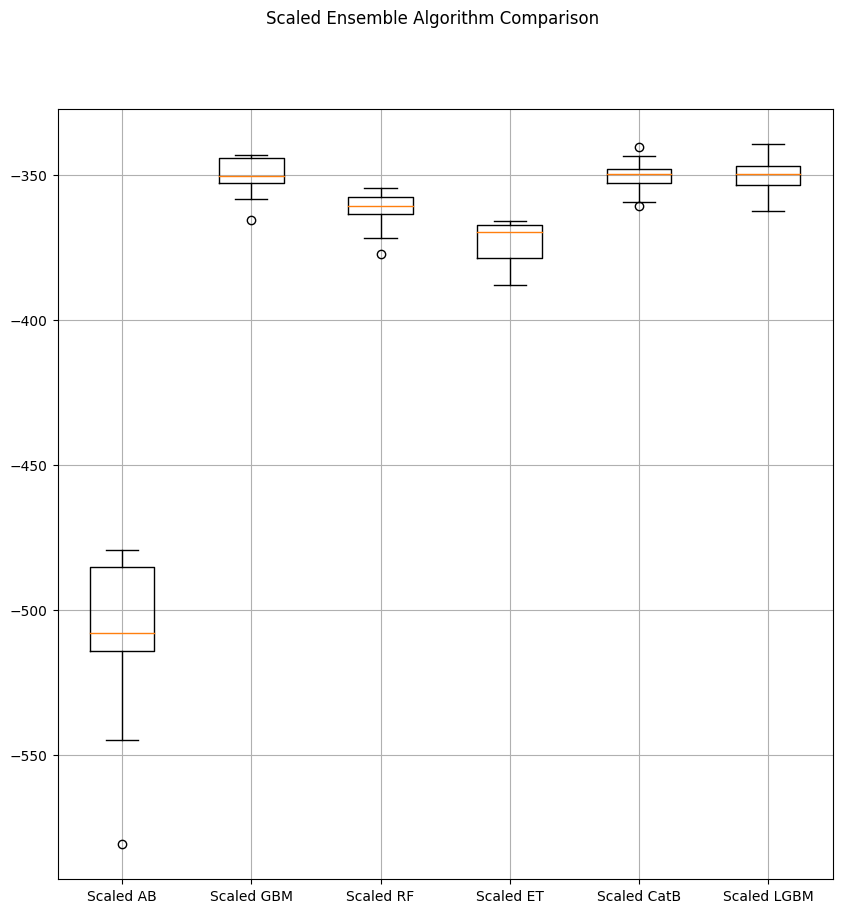

In [77]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

In [78]:
evaluation_results

{'LR': -368.31312246315264,
 'LASSO': -375.61714598278456,
 'EN': -427.09144817857043,
 'KNN': -443.9512984362552,
 'CART': -518.592512225083,
 'SVR': -415.7815111677296,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -372.06157190141494,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -518.0312215008764,
 'Normalized SVR': -569.5600323188185,
 'Scaled LR': -368.31312246315275,
 'Scaled LASSO': -368.58973770882915,
 'Scaled EN': -437.08073593977076,
 'Scaled KNN': -436.56557590398154,
 'Scaled CART': -517.916679931842,
 'Scaled SVR': -370.23802721791776,
 'AB': -508.0325976012693,
 'GBM': -350.48066864437317,
 'RF': -362.86660686793704,
 'ET': -373.42552363182324,
 'CatB': -349.98688839740936,
 'LGBM': -349.5591466110024,
 'Scaled AB': -510.3225917935242,
 'Scaled GBM': -350.56161651321577,
 'Scaled RF': -362.31653173764556,
 'Scaled ET': -373.0088553901015,
 'Scaled CatB': -350.43273582357403,
 'Scale

### Improve Results With Tuning

In [87]:
# Tune scaled LGBM
scaler = StandardScaler().fit(train_data)
rescaledX = scaler.transform(train_data)

param_grid = {
    # 'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'n_estimators':[20,50,100,200,400],
    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3],
    # 'subsample':[0.5 , 0.75 , 1],
    # 'min_samples_split':[2,5,10],
    # 'min_samples_leaf':[1,2,5],
    'max_depth':[2,3,5,7],
    'random_state':[42],
    # 'max_features': ['auto','sqrt'],
    # 'validation_fraction':[0.1,0.2,0.3],
    # 'n_iter_no_change':[1,2]
    }

model = LGBMRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(rescaledX, train_target)
grid_result2 = grid2.fit(rescaledX, train_target)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print("%f (%f) with: %r" % (mean, stdev, param))

Best: -348.397540 using {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
Best: -348.555480 using {'random_state': 42, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


## Summary

In [ ]:
evaluation_results

{'LR': -368.75695861636086,
 'LASSO': -376.86588920927574,
 'EN': -429.8502373572689,
 'KNN': -448.521877704675,
 'CART': -520.0622458162316,
 'SVR': -417.49546621946973,
 'Poly Feat': 361.7299,
 'Normalized LR': -368.7569586163609,
 'Normalized LASSO': -369.9609636521184,
 'Normalized EN': -892.0887801743971,
 'Normalized KNN': -445.3077721285232,
 'Normalized CART': -521.8144266237124,
 'NormalizedSVR': -569.5600323188185,
 'Scaled LR': -368.7569586163611,
 'Scaled LASSO': -368.6484341286584,
 'Scaled EN': -439.84917660151893,
 'Scaled KNN': -438.0745785771219,
 'Scaled CART': -521.9051259359331,
 'Scaled SVR': -370.6807183338712,
 'Scaled AB': -506.8823684900447,
 'Scaled GBM': -350.4869443761551,
 'Scaled RF': -362.45388685993737,
 'Scaled ET': -373.3790824773753,
 'Scaled CatB': -350.43273582357403,
 'Scaled LGBM': -350.0557326010677}

In [79]:
keys = list(evaluation_results.keys())
values = list(evaluation_results.values())
values_abs = []
for value in values:
  values_abs.append(abs(value))
sorted_value_index = np.argsort(values_abs)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
 
top_models = pd.DataFrame.from_dict(sorted_dict, orient='index',columns=['top_model'])
top_models

,top_model
LGBM,-349.559147
CatB,-349.986888
Scaled LGBM,-350.055733
Scaled CatB,-350.432736
GBM,-350.480669
Scaled GBM,-350.561617
Poly Feat,361.729900
Scaled RF,-362.316532
RF,-362.866607
LR,-368.313122


## Finalize Model

In [ ]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
# model = AdaBoostRegressor(n_estimators=400)
model = LGBMRegressor()
model.fit(rescaledX, y_train)

GradientBoostingRegressor()

In [ ]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)

print(f'MAE on train: {regression_results(y_train, model.predict(rescaledX))}')
print(f'MAE on test: {regression_results(y_test, predictions)}')

MAE on train: 342.1429
MAE on test: 344.4368


### With feature selection - SelectKBest

In [49]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model2 = LinearRegression()
model2.fit(X_train_fs, y_train)
# evaluate the model
yhat2 = model2.predict(X_test_fs)
# evaluate predictions
mae2 = mean_absolute_error(y_test, yhat2)
print('MAE: %.3f' % mae2)

# fit the model
model3 = LinearRegression()
model3.fit(X_train_fs_mut, y_train_for_fs)
# evaluate the model
yhat3 = model3.predict(X_test_fs_mut)
# evaluate predictions
mae3 = mean_absolute_error(df_test.drop(['type'],axis=1), yhat3)
print('MAE: %.3f' % mae2)

MAE: 361.965


ValueError: ignored

## SelectKBest tuning (the Number of Selected Features)

In [ ]:
# define the evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# define the pipeline to evaluate
model = LGBMRegressor()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lgbm', model)])

# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(1, 16+1)]

# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

# perform the search
results = search.fit(df_train.iloc[:,0:16], df_train['yield'])

# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print('>%.3f with: %r' % (mean, param))

Best MAE: -351.068
Best Config: {'sel__k': 16}
>-382.508 with: {'sel__k': 1}
>-359.480 with: {'sel__k': 2}
>-354.026 with: {'sel__k': 3}
>-353.151 with: {'sel__k': 4}
>-353.405 with: {'sel__k': 5}
>-353.003 with: {'sel__k': 6}
>-352.765 with: {'sel__k': 7}
>-352.719 with: {'sel__k': 8}
>-352.588 with: {'sel__k': 9}
>-352.440 with: {'sel__k': 10}
>-351.293 with: {'sel__k': 11}
>-351.561 with: {'sel__k': 12}
>-351.274 with: {'sel__k': 13}
>-351.299 with: {'sel__k': 14}
>-351.241 with: {'sel__k': 15}
>-351.068 with: {'sel__k': 16}


In [ ]:
# define the evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# define the pipeline to evaluate
model = LGBMRegressor()
fs = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lgbm', model)])

# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(1, 16+1)]

# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

# perform the search
results = search.fit(df_train.iloc[:,0:16], df_train['yield'])

# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print('>%.3f with: %r' % (mean, param))

Best MAE: -351.108
Best Config: {'sel__k': 14}
>-382.508 with: {'sel__k': 1}
>-359.482 with: {'sel__k': 2}
>-353.972 with: {'sel__k': 3}
>-353.299 with: {'sel__k': 4}
>-353.391 with: {'sel__k': 5}
>-353.022 with: {'sel__k': 6}
>-353.343 with: {'sel__k': 7}
>-353.432 with: {'sel__k': 8}
>-352.990 with: {'sel__k': 9}
>-353.260 with: {'sel__k': 10}
>-351.350 with: {'sel__k': 11}
>-351.467 with: {'sel__k': 12}
>-351.203 with: {'sel__k': 13}
>-351.108 with: {'sel__k': 14}
>-351.144 with: {'sel__k': 15}
>-351.143 with: {'sel__k': 16}


## RFECV

In [50]:
min_features_to_select = 1  # Minimum number of features to consider
estimator = GradientBoostingRegressor()
cv_rfecv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# create pipeline
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv_rfecv,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
model = LGBMRegressor()
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])

# evaluate model
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, df_train.iloc[:,0:16], df_train['yield'], scoring='neg_mean_absolute_error', cv=cv_rfecv)
# report performance
print('MAE: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

KeyboardInterrupt: ignored

### RFECV tuning

In [ ]:
# get a list of models to evaluate
def get_models():
  models = dict()
  # lr
  rfecv = RFECV(estimator=LinearRegression(), scoring="neg_mean_absolute_error")
  model = LGBMRegressor()
  models['lr'] = Pipeline(steps=[('s',rfecv),('m',model)])
  
  # lgbm
  rfecv = RFECV(estimator=LGBMRegressor(), scoring="neg_mean_absolute_error")
  model = LGBMRegressor()
  models['gbr'] = Pipeline(steps=[('s',rfecv),('m',model)])
  
  # gbm
  rfecv = RFECV(estimator=GradientBoostingRegressor(), scoring="neg_mean_absolute_error")
  model = LGBMRegressor()
  models['gbr'] = Pipeline(steps=[('s',rfecv),('m',model)])

  for i in range(2, 16):
    rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
    model = LGBMRegressor()
    models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
  scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  return scores


# get the models to evaluate
models = get_models()


# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, df_train.iloc[:,0:16], df_train['yield'])
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr -351.359 (10.815)
>en -350.936 (10.588)


KeyboardInterrupt: ignored

In [ ]:
models.items()

dict_items([('2', Pipeline(steps=[('s',
                 RFE(estimator=DecisionTreeRegressor(),
                     n_features_to_select=2)),
                ('m', GradientBoostingRegressor())]))])